# Diabetes prediction: decision tree

## Notebook set-up

In [1]:
# Python standard library imports
import pickle
from pathlib import Path
from itertools import combinations

# PyPI imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier

# Internal imports
import configuration as config
import functions as funcs

## 1. Data loading

### 1.1. Load data from URL

In [2]:
url = 'https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv'
data_df = pd.read_csv(url)
data_df.drop_duplicates().reset_index(drop=True, inplace=True)

### 1.2. Save a local copy

In [3]:
# Save to a local file
data_df.to_csv("diabetes.csv", index=False)



### 1.3. Inspect

In [11]:
data_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


## 2. EDA
### 2.1. Data composition

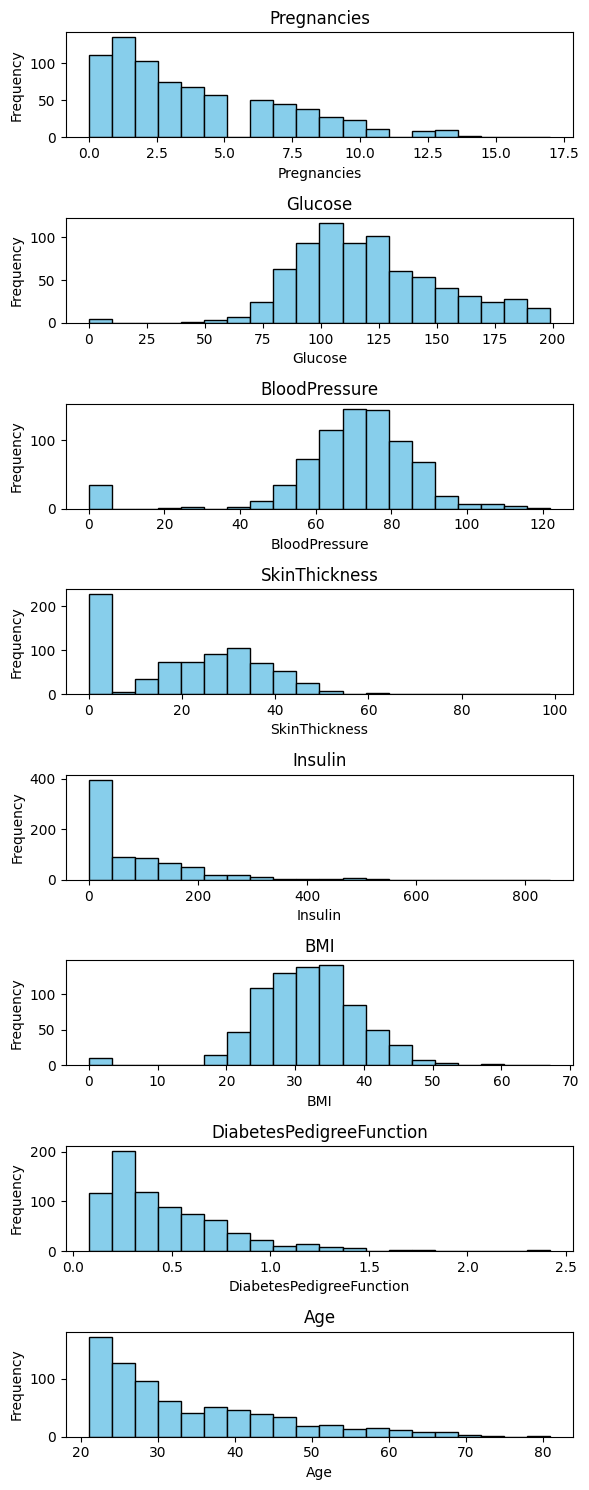

In [ ]:
features = ['Pregnancies','Glucose','BloodPressure','SkinThickness',
            'Insulin','BMI','DiabetesPedigreeFunction','Age']

# Plot feature distributions with histograms
fig, axes = plt.subplots(nrows=len(features), ncols=1, figsize=(6, 15))

for ax, feature in zip(axes, features):
    ax.hist(data_df[feature], bins=20, color='skyblue', edgecolor='black')
    ax.set_title(feature)
    ax.set_xlabel(feature)       
    ax.set_ylabel("Frequency")   

plt.tight_layout()
plt.show()


### 2.2. Feature interactions

#### 2.2.1. Feature cross-correlations

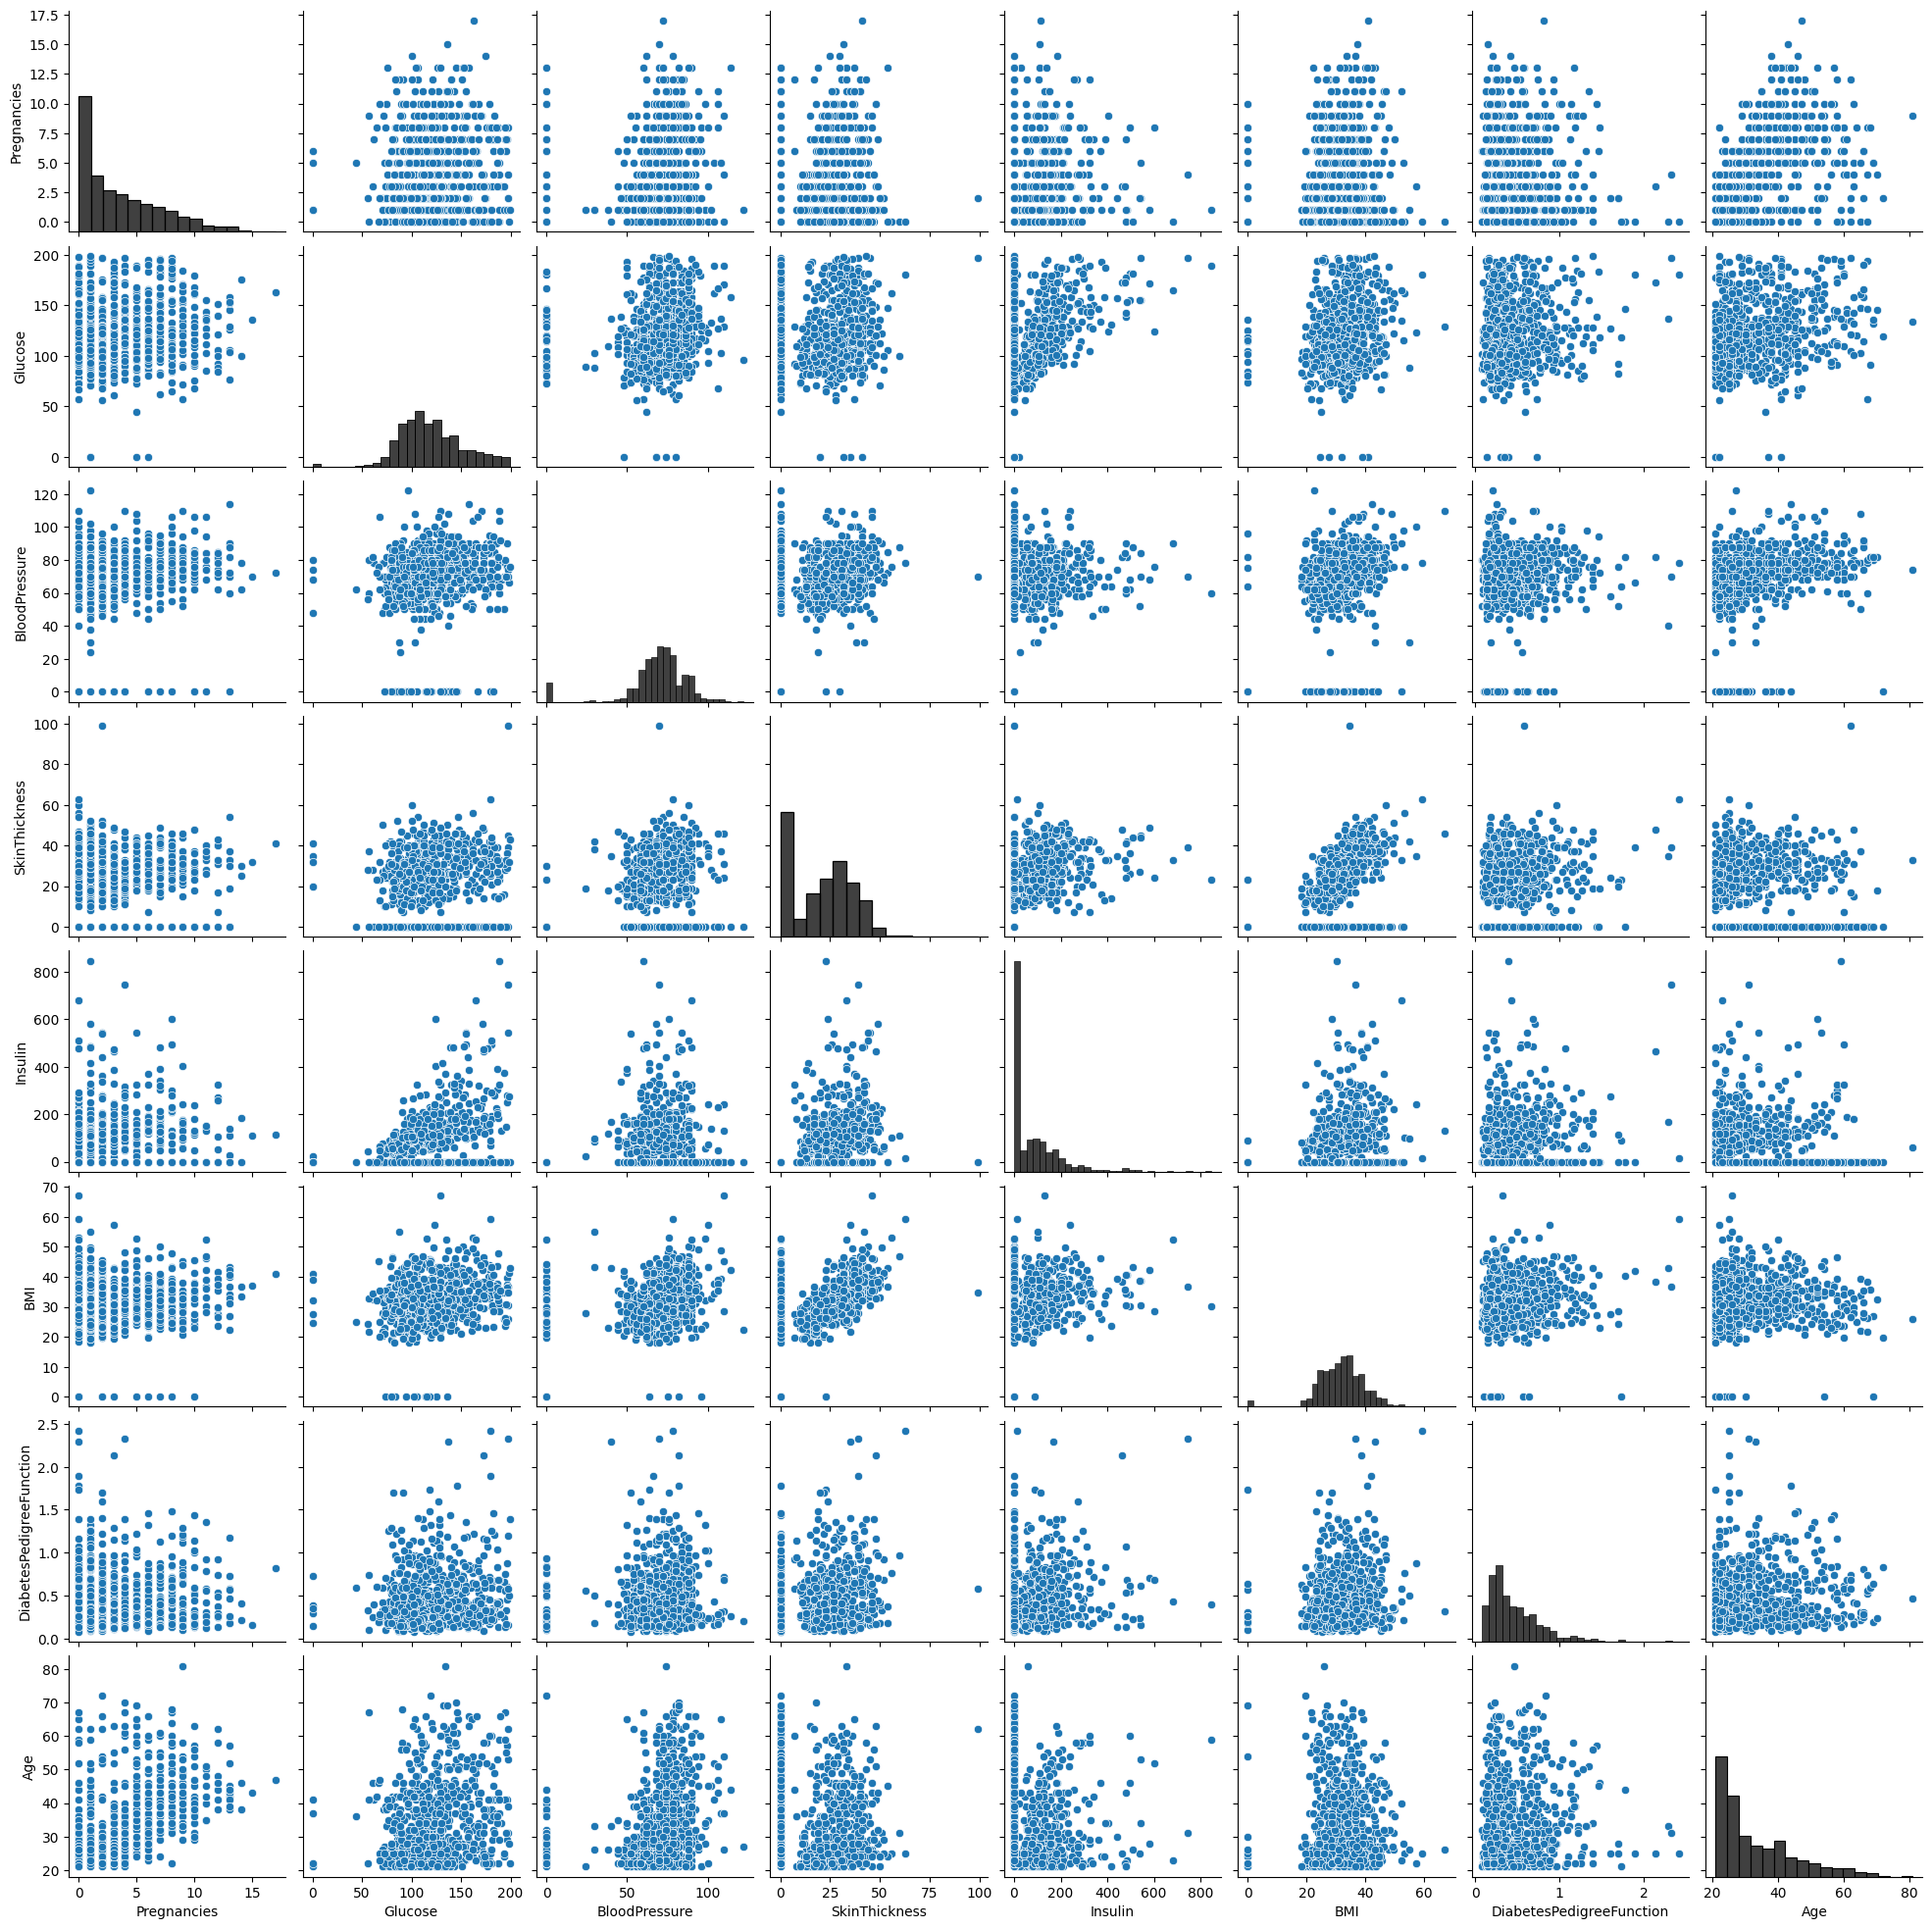

In [14]:
# Draw scatter plots to show the correlation between each pair of features
sns.pairplot(
    data_df[features],
    diag_kind="hist",
    diag_kws={"color": "black", "edgecolor": "black"}  # black bars with black edges
)

plt.show()

#### 2.2.2. Feature-label interactions

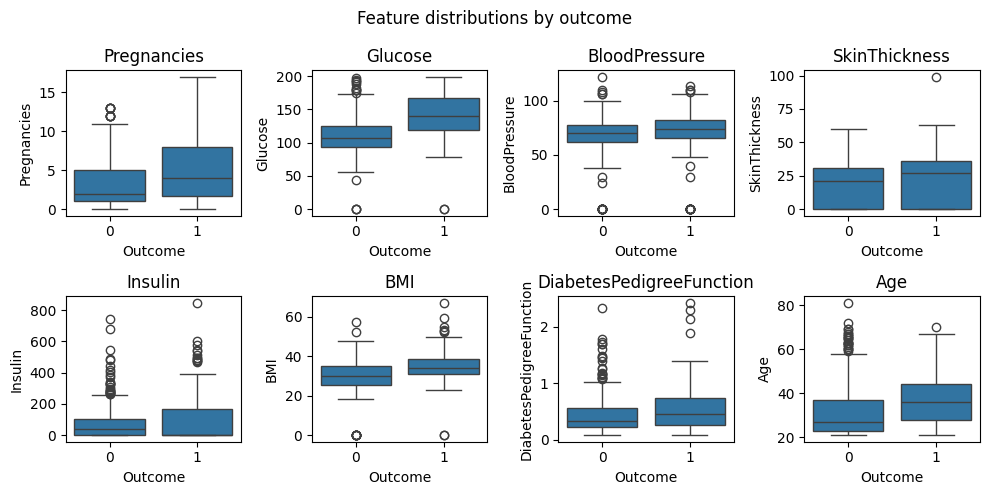

In [19]:
# Use box plots to show the distribution for each feature in diabetes positive and negative populations
fig, axs = plt.subplots(2,4, figsize=(10,5))
axs = axs.flatten()

fig.suptitle('Feature distributions by outcome')

for i, feature in enumerate(features):

    sns.boxplot(data_df, x='Outcome', y=feature, ax=axs[i])
    axs[i].set_title(feature)

fig.tight_layout()

## 3. Data preparation

### 3.1. Test-train split

In [27]:
# Your code here
training_df, testing_df = train_test_split(
    data_df,
    test_size=0.5
)

print(f'Training set: {len(training_df)} rows')
print(f'Testing set: {len(testing_df)} rows')

Training set: 384 rows
Testing set: 384 rows


### 3.2. Imputation of zeros

In [28]:
# Take a close look at zero values in each feature. Is something strange going on?
(data_df[features] == 0).sum()


Pregnancies                 111
Glucose                       0
BloodPressure                 0
SkinThickness                 0
Insulin                       0
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
dtype: int64

In [29]:
# Devise and implement a strategy to fill in zeros with reasonable values
cols_with_invalid_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
data_df[cols_with_invalid_zeros] = data_df[cols_with_invalid_zeros].replace(0, np.nan)

## 4. Model training

### 4.1. Baseline

In [30]:
from sklearn.metrics import accuracy_score, classification_report

# Set a performance baseline
baseline_model = LogisticRegression(max_iter=1000)
baseline_model.fit(X_train, y_train)

y_pred = baseline_model.predict(X_test)

print("Baseline Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Baseline Accuracy: 0.7142857142857143

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.82      0.79       100
           1       0.61      0.52      0.56        54

    accuracy                           0.71       154
   macro avg       0.68      0.67      0.67       154
weighted avg       0.71      0.71      0.71       154



### 4.2. Decision tree classifier

In [31]:
# Train and evaluate a decision tree
model = DecisionTreeClassifier(class_weight='balanced')
model.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])
accuracy = accuracy_score(model.predict(training_df.drop('Outcome', axis=1)), training_df['Outcome'])*100
print(f'Training accuracy of decision tree model: {accuracy:.1f}%')

Training accuracy of decision tree model: 99.7%


In [32]:
# Use cross validation to evaluate the model's performance:
# see: https://scikit-learn.org/stable/modules/cross_validation.html

cross_val_scores = {
    'Model': [],
    'Score': []
}

scores = cross_val_score(
    model,
    training_df.drop('Outcome', axis=1),
    training_df['Outcome'],
    cv=7,
    n_jobs=-1
)

cross_val_scores['Model'].extend(['Baseline']*len(scores))
cross_val_scores['Score'].extend(scores*100)

print(f'Cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Cross-validation accuracy: 69.0 +/- 3.8%


## 4. Hyperparameter optimization

### 4.1. Hyperparameter grid search

In [ ]:
# Perform a grid search on some or all of the hyperparameters from the slides
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "splitter": ["best", "random"],
    "max_depth": [None, 3, 5, 7, 9, 12, 15, 20],
    "min_weight_fraction_leaf": [0.0, 1e-4, 1e-3, 1e-2, 5e-2],
    "max_features": [None, "sqrt", "log2", 0.3, 0.5, 0.7, 0.9],
    "min_impurity_decrease": [0.0, 1e-4, 1e-3, 1e-2],
    "ccp_alpha": [0.0, 1e-5, 1e-4, 1e-3, 1e-2],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=DecisionTreeClassifier(class_weight="balanced", random_state=42),
    param_grid=param_grid,
    scoring={"accuracy": "accuracy", "f1": "f1"},
    refit="f1",                
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    verbose=1,
)

X_train = training_df.drop("Outcome", axis=1)
y_train = training_df["Outcome"]

grid.fit(X_train, y_train)

best_model = grid.best_estimator_
best_params = grid.best_params_

print("Best hyperparameters:\n")
for k, v in best_params.items():
    print(f" {k}: {v}")


Fitting 3 folds for each of 33600 candidates, totalling 100800 fits
Best hyperparameters:

 ccp_alpha: 0.0
 criterion: entropy
 max_depth: 5
 max_features: sqrt
 min_impurity_decrease: 0.0
 min_weight_fraction_leaf: 0.05
 splitter: best


### 4.2. Hyperparameter optimization results

In [49]:
# Evaluate the results



## 5. Evaluation

### 5.1. Model comparison

In [ ]:
# Compare the naive to the optimized model


### 5.2. Test set performance

In [ ]:
# Evaluate the model on the test set


## 6. Save

### 6.1. Data

In [ ]:
Path('../data/raw').mkdir(exist_ok=True, parents=True)
data_df.to_parquet(config.RAW_DATA_FILE)

Path('../data/processed').mkdir(exist_ok=True, parents=True)
data={
    'training': training_df,
    'testing': testing_df
}

with open(config.DATA_FILE, 'wb') as output_file:
    pickle.dump(data, output_file)

### 6.2. Optimized hyperparameters

In [ ]:
Path('../models').mkdir(exist_ok=True, parents=True)

with open(config.DECISION_TREE_HYPERPARAMETERS, 'wb') as output_file:
    pickle.dump(hyperparameters, output_file)

### 6.3. Model

In [ ]:
with open(config.DECISION_TREE_MODEL, 'wb') as output_file:
    pickle.dump(model, output_file)